In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import keras
from keras import layers
from keras.layers import Dense, Flatten, Conv2D
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import os
from IPython import display
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd
import pandas as pd

In [2]:
model = keras.models.load_model("./Training/processor.h5")

In [3]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
def preprocess(file_path, label):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [5]:
POS = os.path.join('Training', 'Data', 'WakeWord', 'Homebot')
NEG = os.path.join('Training', 'Data', 'WakeWord', 'Other')

In [6]:
pos = tf.data.Dataset.list_files(POS +'/*.wav')
neg = tf.data.Dataset.list_files(NEG +'/*.wav')

In [7]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
                                
data = positives.concatenate(negatives)

In [8]:
lengths = []
for file in os.listdir(os.path.join('Training', 'Data', 'WakeWord', 'Homebot')):
    tensor_wave = load_wav(os.path.join('Training', 'Data', 'WakeWord', 'Homebot', file))
    lengths.append(len(tensor_wave))

In [9]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

b'Training\\Data\\WakeWord\\Homebot\\HOMEBOT15.wav'


<function matplotlib.pyplot.show(close=None, block=None)>

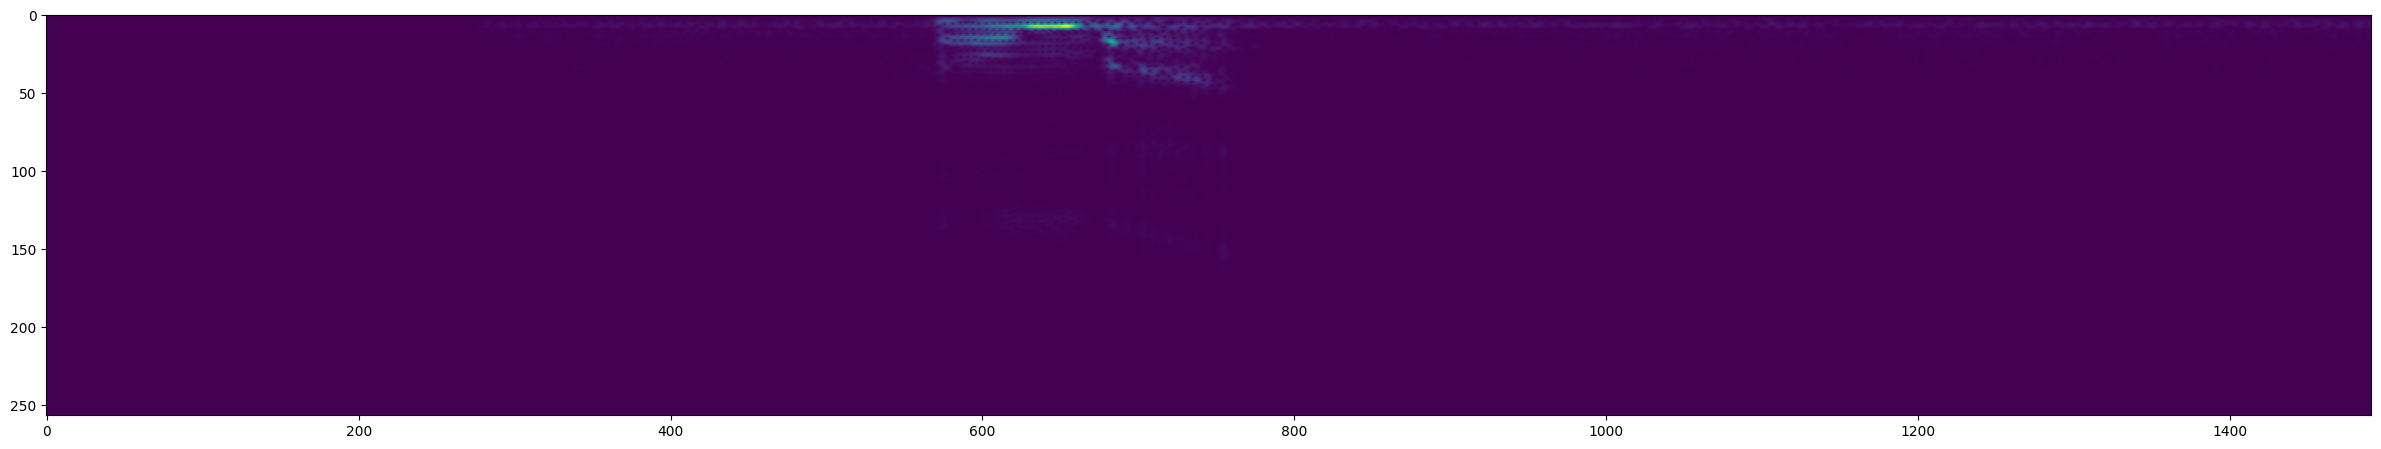

In [10]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [11]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
train = data.take(8)
test = data.skip(8).take(1)

In [13]:
preds = model.predict(train)
preds

8/8 [==============================] - 5s 339ms/step


array([[2.80831358e-17],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [3.87520253e-17],
       [6.57165483e-17],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.79948004e-17],
       [1.00000000e+00],
       [8.19906073e-14],
       [5.99077684e-17],
       [1.99837161e-16],
       [5.01892300e-17],
       [9.66239790e-15],
       [1.00000000e+00],
       [1.20904374e-17],
       [1.00000000e+00],
       [3.38238520e-17],
       [6.23427234e-17],
       [1.61094645e-15],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.80942467e-17],
       [1.01920543e-16],
       [2.41478406e-17],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.28005293e-16],
       [4.08174093e-17],
       [6.23543428e-18],
       [1.17632468e-16],
       [1.00000000e+00],
       [1.35088216e-16],
       [8.89183888e-17],
       [3.55341439e-17],


In [14]:
def wake():
    print("WAKE DETECTED")

In [15]:

from datetime import date
from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y")

In [16]:
results = ['1' if x > 0.5 else 0 for x in preds]
for i in range(len(results)):
    results[i] = bool(results[i])
    if(bool(results[i])):
        wake()
log = pd.DataFrame(preds)
log.to_csv('Logs' + '/' + 'log ' + now + '.csv', index=False)

WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
WAKE DETECTED
